<a href="https://colab.research.google.com/github/currencyfxjle/Machine_Learning_Visualization/blob/main/Visualizacion_de_Machine_Learning_JoseLizarraga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**XGBoost**

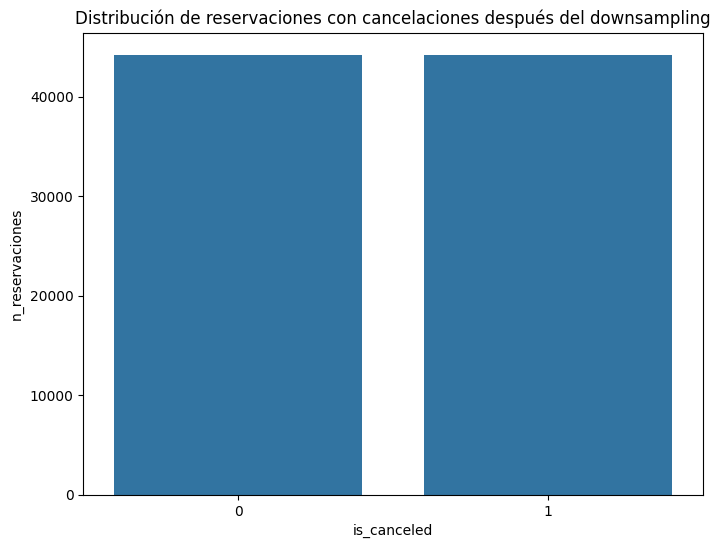

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.20014286128198325, max_depth=4, min_child_weight=1, n_estimators=45, subsample=0.5780093202212182; total time=   0.2s
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.20014286128198325, max_depth=4, min_child_weight=1, n_estimators=45, subsample=0.5780093202212182; total time=   0.2s
[CV] END colsample_bytree=0.5779972601681014, learning_rate=0.021616722433639893, max_depth=2, min_child_weight=3, n_estimators=46, subsample=0.5282057895135501; total time=   0.2s
[CV] END colsample_bytree=0.5779972601681014, learning_rate=0.021616722433639893, max_depth=2, min_child_weight=3, n_estimators=46, subsample=0.5282057895135501; total time=   0.2s
[CV] END colsample_bytree=0.8609993861334124, learning_rate=0.19771054180315006, max_depth=3, min_child_weight=1, n_estimators=57, subsample=0.6521211214797689; total time=   0.2s
[CV] END colsample_bytree=0.860999386

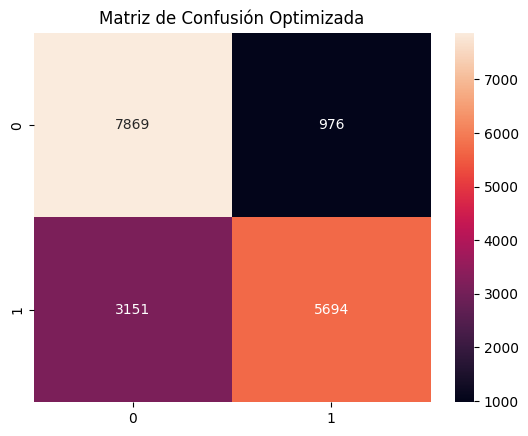

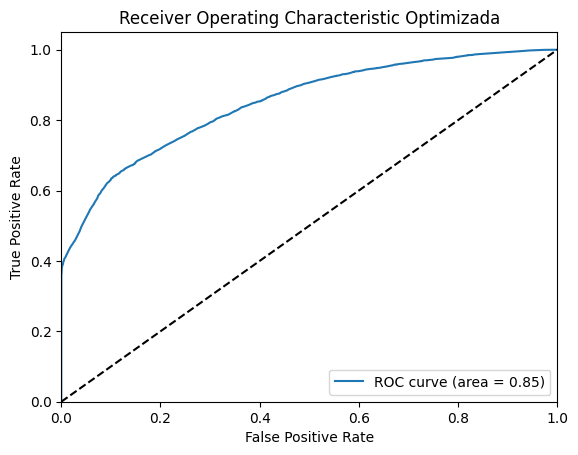

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

# Cargar tus datos
df = pd.read_csv('/content/Reto_hotels.csv')

# Asegurándose de que el índice del DataFrame es un ID único para cada fila
df.reset_index(inplace=True)
df.rename(columns={'index': 'reservation_id'}, inplace=True)

# Realizar downsampling
def fun_downsample(tbl):
    tbl_reservations_not_cancelled = (
        tbl
        .query('is_canceled == 0')
        .sample(
            n=tbl.groupby(['is_canceled']).size()[1],
            random_state=42)
    )

    tbl_reservations_cancelled = tbl.query('is_canceled == 1')

    return pd.concat([
        tbl_reservations_not_cancelled,
        tbl_reservations_cancelled
    ])

tbl_downsampled_data = fun_downsample(df)

# Verificar la distribución de clases después del downsampling
class_distribution = (
    tbl_downsampled_data
    .groupby(['is_canceled'])
    .size()
    .reset_index(name='n_reservaciones')
    .assign(pct=lambda df_: df_.n_reservaciones / df_.n_reservaciones.sum() * 100)
    .round(1)
)

# Gráfico de barras para mostrar la distribución de clases
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    data=class_distribution,
    x='is_canceled',
    y='n_reservaciones'
)
plt.title("Distribución de reservaciones con cancelaciones después del downsampling")
plt.show()

# Continúa con la selección de características y el objetivo, pero utiliza los datos downsampleados
X = tbl_downsampled_data[['lead_time', 'total_of_special_requests', 'deposit_type', 'previous_cancellations', 'market_segment']]
y = tbl_downsampled_data['is_canceled']

# Codificación One-Hot para variables categóricas
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(ohe.fit_transform(X.select_dtypes('object')), index=X.index)
X = pd.concat([X.select_dtypes(exclude='object'), X_encoded], axis=1)

# Dividir en entrenamiento y prueba después del downsampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# El resto de tu código para ajustar el modelo, realizar búsqueda de hiperparámetros, etc.

# Espacio de búsqueda de hiperparámetros ajustado
param_distributions = {
    'n_estimators': randint(25, 100),  # Rango más estrecho
    'learning_rate': uniform(0.01, 0.2),  # Rango más estrecho
    'subsample': uniform(0.5, 0.5),
    'max_depth': randint(2, 5),  # Rango más estrecho
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 4)  # Rango más estrecho
}

# Crear el modelo XGBClassifier para Random Search
xgb = XGBClassifier()

# Random Search con menos iteraciones y menos validaciones cruzadas
random_search = RandomizedSearchCV(xgb, param_distributions, n_iter=10, scoring='roc_auc', cv=2, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", random_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
xgb_model_optimized = random_search.best_estimator_
xgb_model_optimized.fit(X_train, y_train)

# Métricas y evaluación del modelo optimizado
y_pred_optimized = xgb_model_optimized.predict(X_test)
print("Métricas del modelo optimizado XGBoost:")
print(classification_report(y_test, y_pred_optimized))
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_optimized, annot=True, fmt="d")
plt.title("Matriz de Confusión Optimizada")
plt.show()

# Curva ROC y AUC Score del modelo optimizado
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, xgb_model_optimized.predict_proba(X_test)[:, 1])
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Optimizada')
plt.legend(loc="lower right")
plt.show()

# Generar las probabilidades de cancelación para el conjunto de prueba
y_pred_proba = xgb_model_optimized.predict_proba(X_test)[:, 1]

# Crear un DataFrame con los IDs de las reservaciones del conjunto de prueba
result_df = pd.DataFrame(df.loc[X_test.index, 'reservation_id'])

# Agregar las probabilidades y las clasificaciones de cancelación
result_df['cancel_probability'] = y_pred_proba
result_df['is_canceled_pred'] = y_pred_optimized

# Guardar el DataFrame resultante en un archivo CSV
result_df.to_csv('/content/reservation_predictions_xgb.csv', index=False)


In [2]:
# Save the DataFrame as an Excel file
result_df.to_excel('/content/reservation_predictions_xgb.xlsx', index=False)


**Random Forest**

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=34; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=34; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=4, min_samples_split=6, n_estimators=34; total time=   0.8s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=40; total time=   1.1s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=40; total time=   1.0s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=40; total time=   1.1s
[CV] END max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=94; total time=   2.4s
[CV] END max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=94; total time=   2.7s
[CV] END max_depth=11, min_samples_leaf=2, min_samples_split=4, n_estimators=94; total time=   3.1s
[CV] END max_depth=15, min_samples_leaf

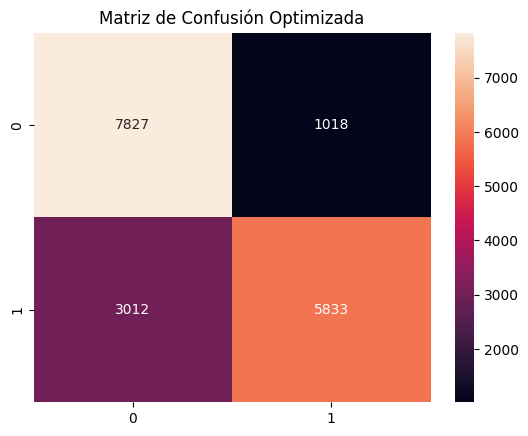

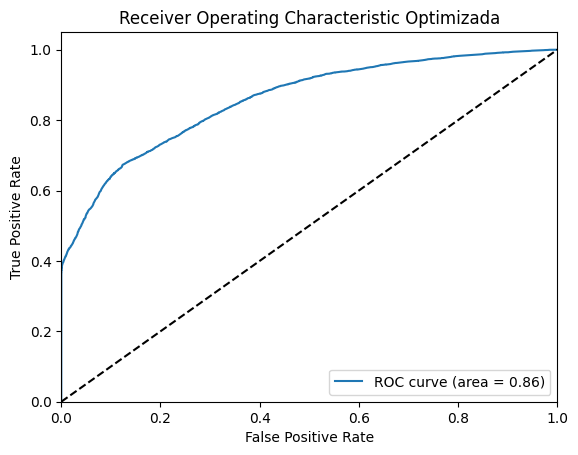

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

# Cargar tus datos
df = pd.read_csv('/content/Reto_hotels.csv')

# Asegurándose de que el índice del DataFrame es un ID único para cada fila
df.reset_index(inplace=True)
df.rename(columns={'index': 'reservation_id'}, inplace=True)

# Realizar downsampling
def fun_downsample(tbl):
    tbl_reservations_not_cancelled = (
        tbl
        .query('is_canceled == 0')
        .sample(
            n=tbl.groupby(['is_canceled']).size()[1],
            random_state=42)
    )

    tbl_reservations_cancelled = tbl.query('is_canceled == 1')

    return pd.concat([
        tbl_reservations_not_cancelled,
        tbl_reservations_cancelled
    ])

tbl_downsampled_data = fun_downsample(df)

# Continúa con la selección de características y el objetivo, pero utiliza los datos downsampleados
X = tbl_downsampled_data[['lead_time', 'total_of_special_requests', 'deposit_type', 'previous_cancellations', 'market_segment']]
y = tbl_downsampled_data['is_canceled']

# Codificación One-Hot para variables categóricas
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(ohe.fit_transform(X.select_dtypes('object')), index=X.index)
X = pd.concat([X.select_dtypes(exclude='object'), X_encoded], axis=1)

# Convierte todos los nombres de las columnas a strings
X.columns = X.columns.astype(str)

# Dividir en entrenamiento y prueba después del downsampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Espacio de búsqueda de hiperparámetros para RandomForest
param_distributions = {
    'n_estimators': randint(20, 100),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Crear el modelo RandomForestClassifier para Random Search
rf = RandomForestClassifier()

# Random Search con RandomForest
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=10, scoring='roc_auc', cv=3, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", random_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
rf_model_optimized = random_search.best_estimator_
rf_model_optimized.fit(X_train, y_train)

# Métricas y evaluación del modelo optimizado
y_pred_optimized = rf_model_optimized.predict(X_test)
print("Métricas del modelo optimizado RandomForest:")
print(classification_report(y_test, y_pred_optimized))
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_optimized, annot=True, fmt="d")
plt.title("Matriz de Confusión Optimizada")
plt.show()

# Curva ROC y AUC Score del modelo optimizado
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, rf_model_optimized.predict_proba(X_test)[:, 1])
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Optimizada')
plt.legend(loc="lower right")
plt.show()

# Generar las probabilidades de cancelación para el conjunto de prueba
y_pred_proba = rf_model_optimized.predict_proba(X_test)[:, 1]

# Crear un DataFrame con los IDs de las reservaciones del conjunto de prueba
result_df = pd.DataFrame(df.loc[X_test.index, 'reservation_id'])

# Agregar las probabilidades y las clasificaciones de cancelación
result_df['cancel_probability'] = y_pred_proba
result_df['is_canceled_pred'] = y_pred_optimized

# Guardar el DataFrame resultante en un archivo CSV
result_df.to_csv('/content/reservation_predictions_rf.csv', index=False)

In [5]:
# Save the DataFrame as an Excel file
result_df.to_excel('/content/reservation_predictions_rf.xlsx', index=False)

**Al comparar los resultados de XGBoost y Random Forest, podemos observar lo siguiente:**

**Precisión y Recall:**

En ambas clases (0 y 1), Random Forest tiene una ligera ventaja en precisión, pero las diferencias son mínimas.
XGBoost y Random Forest tienen un desempeño similar en recall para la clase 0, pero XGBoost tiene un recall ligeramente más bajo para la clase 1.
F1-Score:

Random Forest muestra un **F1-score **ligeramente superior en la clase 0, indicando un mejor balance entre precisión y recall para esta clase.
XGBoost, sin embargo, tiene un F1-score ligeramente más bajo en la clase 1 en comparación con Random Forest.
Precisión Global (Accuracy):

Ambos modelos tienen una **precisión** global idéntica del 77%.
Promedios (Macro y Weighted Avg):

En cuanto a los promedios macro y ponderados, Random Forest tiene una ventaja mínima en ambos, lo que sugiere un rendimiento ligeramente más equilibrado en ambas clases.

**Área bajo la Curva ROC (AUC):**

Random Forest tiene un AUC de 0.86, que es ligeramente superior al AUC de XGBoost de 0.85. Esto implica que, en general, Random Forest es ligeramente mejor en términos de equilibrio entre la tasa de verdaderos positivos y la tasa de falsos positivos.


---



**En conclusión**

aunque ambos modelos muestran un rendimiento similar, Random Forest tiene un ligero borde en términos de equilibrio general y capacidad para distinguir entre las clases. Estas diferencias, aunque mínimas, pueden ser significativas dependiendo de la importancia relativa de precisión y recall para el problema específico en cuestión.


---



**La regresión lineal**, al contrario de modelos más complejos como XGBoost y Random Forest, no ofrece hiperparámetros ajustables en gran medida. Mientras que XGBoost y Random Forest permiten un ajuste fino a través de parámetros como la profundidad del árbol, la tasa de aprendizaje y el número de árboles, la regresión lineal se basa en un enfoque más sencillo y directo sin tales parámetros.

**Linear Regression**

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      8845
           1       0.78      0.68      0.73      8845

    accuracy                           0.75     17690
   macro avg       0.75      0.75      0.75     17690
weighted avg       0.75      0.75      0.75     17690



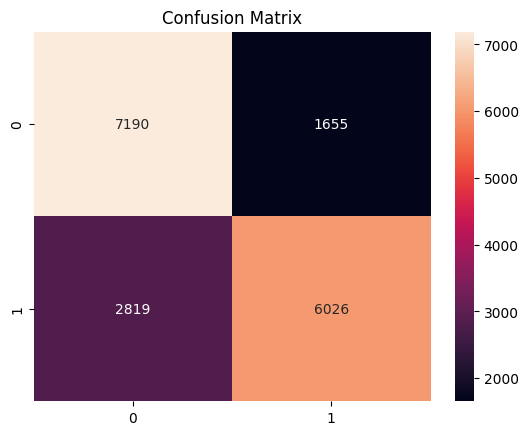

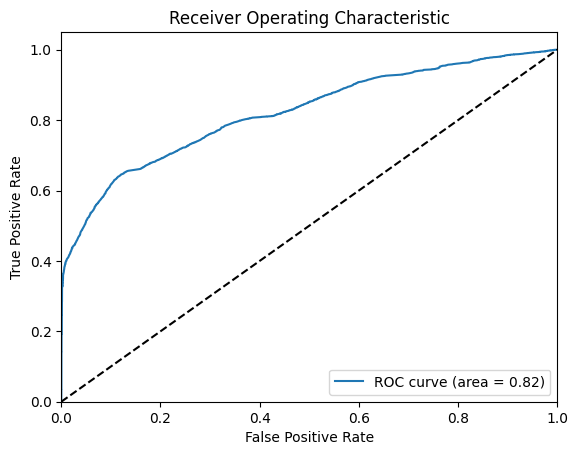

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('/content/Reto_hotels.csv')

# Ensure that DataFrame index is a unique ID for each row
df.reset_index(inplace=True)
df.rename(columns={'index': 'reservation_id'}, inplace=True)

# Check for data imbalance in the target variable
print(df['is_canceled'].value_counts(normalize=True))

# Downsampling to handle data imbalance
def fun_downsample(tbl):
    tbl_reservations_not_cancelled = (
        tbl
        .query('is_canceled == 0')
        .sample(n=tbl.groupby(['is_canceled']).size()[1], random_state=42)
    )
    tbl_reservations_cancelled = tbl.query('is_canceled == 1')
    return pd.concat([tbl_reservations_not_cancelled, tbl_reservations_cancelled])

tbl_downsampled_data = fun_downsample(df)

# Feature selection
X = tbl_downsampled_data[['lead_time', 'total_of_special_requests', 'deposit_type', 'previous_cancellations', 'market_segment']]
y = tbl_downsampled_data['is_canceled']

# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(ohe.fit_transform(X.select_dtypes('object')), index=X.index)
X = pd.concat([X.select_dtypes(exclude='object'), X_encoded], axis=1)

# Convert all column names to strings
X.columns = X.columns.astype(str)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg_model.predict(X_test_scaled)
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# Metrics and model evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Create a DataFrame with the reservation IDs and predictions
result_df = pd.DataFrame(df.loc[X_test.index, 'reservation_id'])
result_df['cancel_probability'] = y_pred_proba
result_df['is_canceled_pred'] = y_pred

# Save the resulting DataFrame to a CSV file
result_df.to_csv('/content/reservation_predictions_LN.csv', index=False)

In [18]:
# Save the DataFrame as an Excel file
result_df.to_excel('/content/reservation_predictions_LN.xlsx', index=False)